# Make a reference mesh for a phagophore rim mesh

The reference mesh has the same shape and size as the rim, but no swelling or constriction.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pyvista as pv
from pyvistaqt import BackgroundPlotter
from scipy.spatial import cKDTree
from collections import namedtuple

# Import custom functions
dir_utilities = Path('../utilities').resolve().as_posix()
if dir_utilities not in sys.path:
    sys.path.insert(0, dir_utilities)

from utility_functions import (normalize_vector, angle_between_vectors_batch)
from fitting_functions import fit_plane, polynomial_surface_fit_v1
from mesh_functions import (find_vertices_cell_ids, mesh_find_borders, get_mean_cell_area, n_connected_regions,
                            mesh_get_connected_border_loops, sort_connected_edges, clean_mesh_after_clipping_v1,
                            triangulate_ladder, mesh_neighbor_id_list, mesh_refine_normals_v1)

from reference_mesh_functions import (move_points_to_parallel_surface_raytrace,
                                      move_points_to_surface_raytrace,
                                      make_toroid_around_spline,
                                      decimate_regular_mesh_v1,
                                      surf_find_new_borders_vertical, 
                                      find_closest_pointcloud, 
                                      check_and_fix_surface)

## Input

In [2]:
# Input files
dir_in = Path('../example_data/rim_analysis')
fnames_in = {'rim_mesh': dir_in / 'rim_mesh_out.vtp',
             'mid_mesh': dir_in / 'mid_surf_mesh_out.vtp',
             'rim_results': dir_in / 'Ph_rim0_results.npy'}

# Parameters ---------------------------------------------

# Pixel size
pix_size = 1.408 # in nm

# Toroid theta resolution
theta_res = 72

# How much of the border is cut away before calculating the bending energy
# Curvature estimation at borders is not as good, see Salfer et al.
curv_dist = 5*pix_size

# Output fname
save_mesh = False
fname_out = dir_in / 'rim_reference_mesh.vtp'

In [3]:
# Plot settings
pv.set_plot_theme('default')
plot_meshes = True
window_size = [300,300]
colors = {'rim': 'white', 'mid': 'yellow'}

# Camera positions (found with BackgroundPlotter -> Save Camera -> plotter.saved_camera_positions)
cpos = {'rim0': [(-386.0689470911347, 250.23796937189678, 307.126759195419),
                  (150.30179583035257, 145.41991491462753, 56.72160155071842),
                  (0.36197519610292567, -0.2753202947385644, 0.8906024324642947)],

        'rim1': [(421.2657093153479, 519.4771750536273, 382.65404351443084),
                  (141.47089385986328, 120.79996538162231, 75.79121339321136),
                  (-0.39103366469324685, -0.3731502872336557, 0.8413391327009635)],
        
        'final': [(113.33731775888543, 306.8710974508956, 276.2042944293537),
                  (114.82376667063657, 160.30693013092318, 45.50448433112392),
                  (-0.4474474551632961, -0.7561597962249655, 0.4775072119255468)]}

### Load data

In [4]:
# Mesh vtp files
rim_mesh = pv.read(fnames_in['rim_mesh'])
mid_mesh = pv.read(fnames_in['mid_mesh'])

# Rim analysis results
res_rim = np.load(fnames_in['rim_results'], allow_pickle=True).item()

# get relevant parameters
imdist_back_mean = res_rim['im_dist']['back']['imdist_back_mean']
cyl_radius = 0.5*imdist_back_mean
tip_spline_smooth = res_rim['data']['tip_spline_smooth']

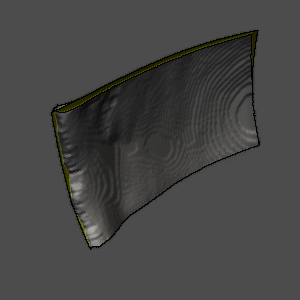

In [5]:
# Plot
if plot_meshes:
    p0 = pv.Plotter(window_size=window_size)
    p0.enable_eye_dome_lighting()
    p0.add_mesh(rim_mesh, color=colors['rim'])
    p0.add_mesh(mid_mesh, color=colors['mid'])
    p0.camera_position = cpos['rim0']
    _ = p0.show()

## Build the parts of the reference mesh

### Back part
Move points in the back to the desired distance from the mid surf

In [6]:
# Exclude points too close to the tip by clipping mesh with a plane

# Get distances of points to tip
tree_tip = cKDTree(tip_spline_smooth)
dist_all_tip, idx_all_tip = tree_tip.query(rim_mesh.points)

# Make a plane for cutting
cutoff_dist=2*cyl_radius
ids_clip_plane = np.where(abs( dist_all_tip - cutoff_dist) < 1)[0]
clip_plane = fit_plane(rim_mesh.points[ids_clip_plane], np.mean(mid_mesh.points, axis=0), N_to_ref=False)

# cut
mesh0 = rim_mesh.clip(normal=clip_plane.normal, origin=clip_plane.center)

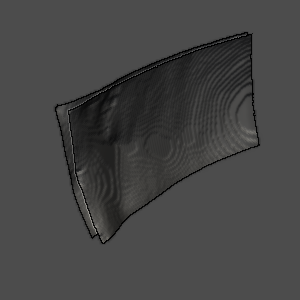

In [7]:
# Plot
if plot_meshes:
    p0 = pv.Plotter(window_size=window_size)
    p0.enable_eye_dome_lighting()
    p0.add_mesh(mesh0, color=colors['rim'])
    p0.camera_position = cpos['rim0']
    _ = p0.show()

In [8]:
# Get front border points of mesh0 --> needed for later stitching
# Front border points are points in the clip_plane!
mesh0_border_verts, mesh0_border_face_ids, mesh0_border_edges = mesh_find_borders(mesh0)
mesh0_border_points = mesh0.points[mesh0_border_verts]

border_dist_clip_plane = np.dot( (mesh0_border_points - clip_plane.center), clip_plane.normal)
mesh0_front_border_ids = mesh0_border_verts[abs(border_dist_clip_plane) < 0.1]

# Get distance to mid surface and move points accordingly
tree_mid = cKDTree(mid_mesh.points)
mesh1 = mesh0.copy()
mesh2 = mesh0.copy()

for i in range(2):
    # For each side of the rim, get the points and move them to a uniform distance to the mid_mesh
    side_cell_ids = np.where(mesh0['point_type'] == i)[0]
    side_point_ids = find_vertices_cell_ids(mesh0, side_cell_ids)
    mesh1.points[side_point_ids] = move_points_to_parallel_surface_raytrace(mesh0.points[side_point_ids], mid_mesh, cyl_radius,
                                                                              tree_surf=tree_mid, same_side=True, add_missing_points=True)
    # Also make a mesh2 which is slightly larger: needed later for making a cutting surface
    mesh2.points[side_point_ids] = move_points_to_parallel_surface_raytrace(mesh0.points[side_point_ids], mid_mesh, 1.5*cyl_radius,
                                                                              tree_surf=tree_mid, same_side=True, add_missing_points=True)


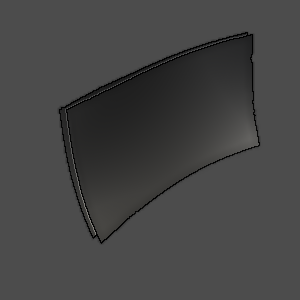

In [9]:
# Plot
if plot_meshes:
    p0 = pv.Plotter(window_size=window_size)
    p0.enable_eye_dome_lighting()
    p0.add_mesh(mesh1, color=colors['rim'])
    p0.camera_position = cpos['rim0']
    _ = p0.show()

### Tip part

In [10]:
# Map tip spline on mid_surf and construct a toroid around it
    
tip_points_mid = move_points_to_parallel_surface_raytrace(tip_spline_smooth, mid_mesh, 0, tree_surf=tree_mid, 
                                                            same_side=False, add_missing_points=False)
# To increase the cell size, decrease z sampling
tip_points_mid_1 = tip_points_mid[::2,:]
if np.all( tip_points_mid[-1] != tip_points_mid_1[-1]):
    tip_points_mid_1 = np.r_[tip_points_mid_1, np.atleast_2d(tip_points_mid[-1])]
    
tip_tor = make_toroid_around_spline(tip_points_mid_1, cyl_radius, theta_res=theta_res)   

In [11]:
# Cut the toroid so only the half toroid facing outwards remains

# Use angle between rim direction and vector from toroid center and the fact that toroid is regular
tor_z_res = int( tip_tor.n_points / theta_res )

# For each toroid point, get corresponding normal of mid surface
_, idx_tm = tree_mid.query(tip_points_mid_1)
tip_mid_normals = mid_mesh['Normals'][idx_tm]

# Get vectors pointing in the rim direction from cross product of mid surf normals and spline vectors
tip_tor['rim_dirs'] = normalize_vector( np.cross(np.repeat(tip_mid_normals, theta_res, axis=0), tip_tor['spline_vectors']) )
reference_vector = normalize_vector( np.mean(tip_points_mid, axis=0) - np.mean(mid_mesh.points, axis=0) )
if np.dot( np.mean(tip_tor['rim_dirs'], axis=0), reference_vector) <0:
    tip_tor['rim_dirs'] *= -1

# Get circle vectors (vector from respective circle center for each point)
tip_tor['vec_from_center'] = normalize_vector( tip_tor.points - tip_tor['circle_centers'] )
# Get angles of circle vectors to rim vectors
tip_tor['ang_circle_rim'] = np.arccos( np.einsum('ij,ij->i', tip_tor['vec_from_center'], tip_tor['rim_dirs']) )

# To get a clean cut, determine cutoff for all points together
ang_tmp = tip_tor['ang_circle_rim'].reshape(tor_z_res, theta_res)
n_ang_to_select = np.sum(ang_tmp <= np.pi / 2, axis=0) # For each set of points around the circle, how many points correspond to the cutoff criterion?
# Selected angles should correspond to roughly half of the overall angles
target_n_angles = int(theta_res/2)
if np.sum( n_ang_to_select > 0) <= target_n_angles:    
    ids_circle_keep = np.where(n_ang_to_select > 0)[0]
else:
    ids_circle_keep = np.sort( np.flip(np.argsort(n_ang_to_select))[:target_n_angles] )

# From ids to keep along the circle, calculate which ids should be removed
ids_circle_all = np.arange(theta_res)
ids_circle_remove = np.delete(ids_circle_all, ids_circle_keep)

# Find ids of all points at the corresponding circle positions    
tip_tor_ids = np.arange(len(tip_tor['ang_circle_rim']))
tip_tor_ids_remove = tip_tor_ids.reshape(tor_z_res, theta_res)[:, ids_circle_remove].flatten()

# Cut!
tip_tor_half, tip_tor_half_old_ids = tip_tor.remove_points(tip_tor_ids_remove, keep_scalars=True, inplace=False)

# Find edges of the half toroid --> needed for stitching later
tmp = np.unique( np.searchsorted(ids_circle_keep, ids_circle_remove))

if len(tmp) == 1:
    tmp = tmp[0]
    if tmp == 0 or tmp == len(ids_circle_keep):
        tor_half_edge_ids = ids_circle_keep[[-1,0]]
    else:    
        tor_half_edge_ids = ids_circle_keep[int(tmp-1):int(tmp+1)]
else :
    tor_half_edge_ids = ids_circle_keep[[-1,0]]

tip_tor_ids_edges = tip_tor_ids.reshape(tor_z_res, theta_res)[:, tor_half_edge_ids].flatten()   
half_edge_ids = np.where( np.in1d(tip_tor_half_old_ids, tip_tor_ids_edges) )[0] # Get new ids of the edges


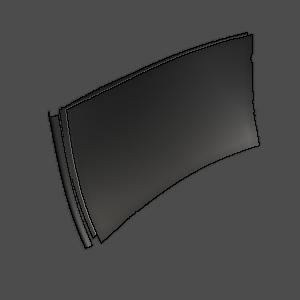

In [12]:
# Plot
if plot_meshes:
    p0 = pv.Plotter(window_size=window_size)
    p0.enable_eye_dome_lighting()
    p0.add_mesh(mesh1, color=colors['rim'])
    p0.add_mesh(tip_tor_half, color=colors['rim'])
    p0.camera_position = cpos['rim0']
    _ = p0.show()

## Connect back and tip

Connecting meshes are constructed from the mid_mesh

### Make filling patches extending over the front

In [13]:
# Create mid_mesh-based meshes at the right positions

# Mark original borders of mid_mesh for later
mid_mesh_border_ids, _, _ = mesh_find_borders(mid_mesh)
tmp = np.zeros(mid_mesh.n_points)
tmp[mid_mesh_border_ids] = 1
mid_mesh['border_orig'] = tmp.copy()

# Decimate the mesh
mid_mesh_mean_area = get_mean_cell_area(mid_mesh)
rim_mesh_mean_area = get_mean_cell_area(rim_mesh)

div_factor = int( np.floor( np.sqrt(rim_mesh_mean_area / mid_mesh_mean_area) ) )
mid_mesh_dec = decimate_regular_mesh_v1(mid_mesh, division_factors=(div_factor,div_factor), 
                                        list_transfer_arrays=['Normals', 'border_orig'])     

# Get fill-in mesh
mid_mesh_side0 = mid_mesh_dec.copy()
mid_mesh_side0.points = mid_mesh_side0.points + cyl_radius*mid_mesh_dec['Normals']
mid_mesh_side0['side'] = np.zeros(mid_mesh_side0.n_points)
mid_mesh_side1 = mid_mesh_dec.copy()
mid_mesh_side1.points = mid_mesh_side1.points - cyl_radius*mid_mesh_dec['Normals']
mid_mesh_side1['side'] = np.ones(mid_mesh_side1.n_points)

mid_mesh_spread = mid_mesh_side0 + mid_mesh_side1

In [14]:
# Cut in the back

# Create surface from back edge points
back_edge_points = mesh1.points[mesh0_front_border_ids]
# Use mesh2 points to make a nice surface for cutting (broader than back_edge_points only)
back_edge_points_expanded = np.r_[back_edge_points, mesh2.points[mesh0_front_border_ids]]
back_edge_surf = polynomial_surface_fit_v1(back_edge_points_expanded, order=2, output_step=1, output_extrapol=0.1, align_surf_z=False,return_grid_info=False)

# Clip the mid mesh
mid_mesh_add_0 = mid_mesh_spread.clip_surface(back_edge_surf, invert=False)
invert_tmp=False
if mid_mesh_add_0.area > 0.5*mid_mesh_spread.area:
    mid_mesh_add_0 = mid_mesh_spread.clip_surface(back_edge_surf, invert=True)
    invert_tmp=True

# Clip mid mesh with some distance for making the filling surface later (patch needs to be a bit smaller than the gap)
patch_gap_size = 0.5
cut_dist = patch_gap_size
if invert_tmp:
    cut_dist *=-1
mid_mesh_add_10 = mid_mesh_spread.clip_surface(back_edge_surf, invert=invert_tmp, value=cut_dist)
# Clean this mesh since it will go into the final mesh
mid_mesh_add_1 = clean_mesh_after_clipping_v1(mid_mesh_add_10, mid_mesh_spread, border_min_ratio=0.3, area_min_ratio=0.1)


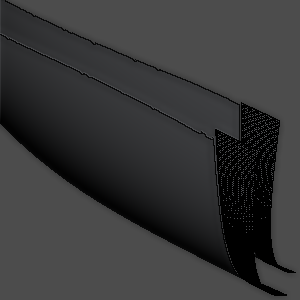

In [15]:
# Plot
if plot_meshes:
    p0 = pv.Plotter(window_size=window_size)
    p0.enable_eye_dome_lighting()
    p0.add_mesh(mesh1, color=colors['rim'])
    p0.add_mesh(mid_mesh_add_10, color='white', show_edges=True)
    p0.camera_position = cpos['final']
    _ = p0.show()

### Find optimal position for front half toroid

In [16]:
from reference_mesh_functions import (get_ebend_area, optimize_toroid_position, get_fill_area_front_position,
                                      make_front_surf)

In [17]:
# Parameters for area calculation
area_param_tuple = namedtuple('area_params', ['z_rim_min', 'z_rim_max', 'curv_dist'])
area_params = area_param_tuple(float( np.min( rim_mesh.points[:,2] )),
                               float( np.max( rim_mesh.points[:,2] )),
                               curv_dist)

# Calculate missing area between back and front
target_area = get_ebend_area(rim_mesh, area_params)  
missing_area_nofront = target_area - get_ebend_area(mesh1, area_params) # target area - back area

In [18]:
# Optimize position of toroid iteratively

iterations=3
tor_half = tip_tor_half.copy()
tor_mid_points = tip_points_mid_1
# Get the front edge points
front_edge_points = tor_half.points[half_edge_ids]
x_bounds = None # Calculate initial x_bounds automatically
res_area = missing_area_nofront
x_init=3
for it in range(iterations):
    if it > 0:
        x_init=0
    print('Iteration {}'.format(it))
    # Skip higher iterations if result was alrady good
    if it > 1:
        if res_area < 1:
            print('Skipping iteration!')
            continue
    # Calculate missing area
    missing_area = missing_area_nofront - get_ebend_area(tor_half, area_params)
    
    # Get the optimal position
    res, vec_front_back = optimize_toroid_position(mid_mesh_add_0, front_edge_points, 
                                                   back_edge_points, area_params, missing_area, x_bounds=x_bounds,
                                                   x_init=x_init)
    
        
    res_area = res.fun
    print(res_area)
    # Move the half toroid: move the middle and make sure it follows the mid mesh, then rebuild the toroid
    # Get the new mid points of the toroid
    tor_mid_points = move_points_to_surface_raytrace(tor_mid_points + res.x*vec_front_back, 
                                                        mid_mesh, tree_surf=tree_mid, 
                                                        add_missing_points=True,
                                                        missing_point_method='continuous')
    
    # Make the new toroid
    tor_new = make_toroid_around_spline(tor_mid_points, cyl_radius, theta_res=theta_res)  
    
    # Assuming ids are the same, make the new half toroid and get its front edge points
    tor_half, _ = tor_new.remove_points(tip_tor_ids_remove, keep_scalars=True, inplace=False)
    # Get the front edge points
    front_edge_points = tor_half.points[half_edge_ids]

    
# After the last iteration, make the final front surf & recalculate back_centroid
front_edge_surf = make_front_surf(front_edge_points)   
back_centroid = np.mean(back_edge_points, axis=0)

Iteration 0
Calculating best position for the toroid.
Resulting x: 3.11. This took 2.2 seconds.
12.367295132726213
Iteration 1
Calculating best position for the toroid.
Resulting x: -0.04. This took 9.5 seconds.
5.410488620327669e-05
Iteration 2
Skipping iteration!


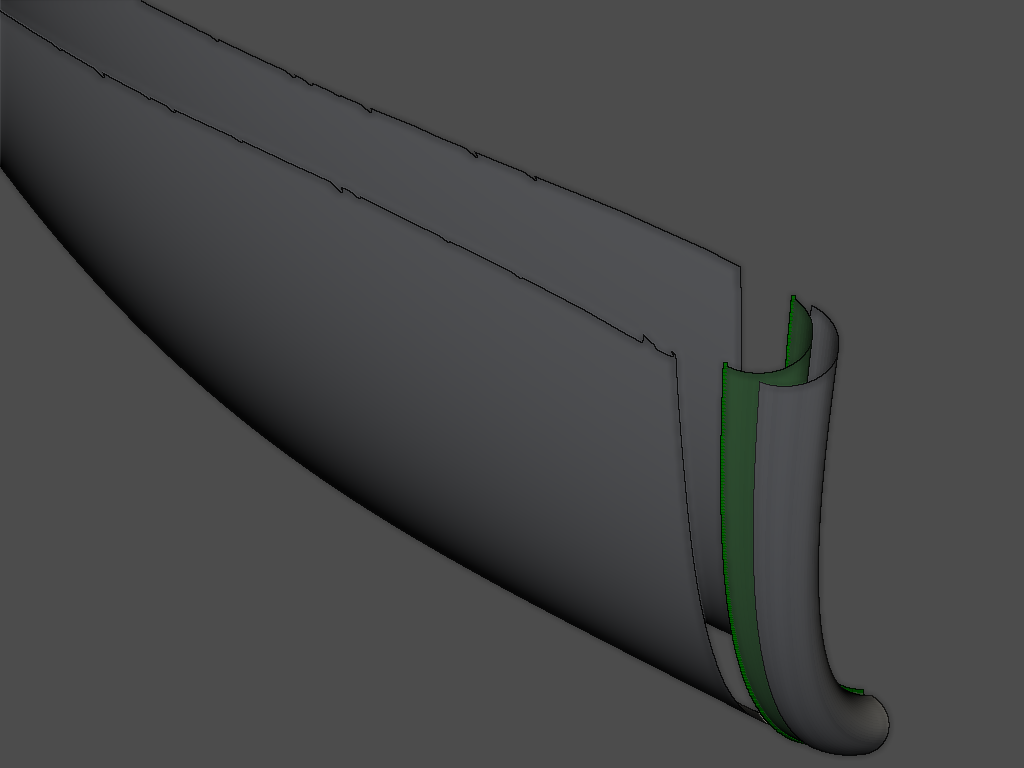

In [19]:
if plot_meshes:
    p1 = pv.Plotter()
    p1.enable_eye_dome_lighting()
    p1.add_mesh(tip_tor_half, color='white')
    p1.add_mesh(mesh1, color='white')
    p1.add_mesh(tor_half, color='lightgreen')
    p1.add_mesh(front_edge_points, color='green')
    p1.camera_position = cpos['final']
    p1.show()

### Cut filling patches in the front

In [20]:
# Generate a smaller mid surf patch for stitching everything together
_, mid_add_surf_small_0, _ = get_fill_area_front_position(patch_gap_size, mid_mesh_add_1, 
                                                          front_edge_surf, vec_front_back, back_centroid, 
                                                          area_params, missing_area=0,return_full=True)

# Clean the surface
mid_add_surf_small = clean_mesh_after_clipping_v1(mid_add_surf_small_0, mid_mesh_add_1, 
                                                  border_min_ratio=0.3, area_min_ratio=0.1, debug=False)

Small face at corner, skipping..
Small face at corner, skipping..
Small face at corner, skipping..
Small face at corner, skipping..
Small face at corner, skipping..


In [21]:
# Sort points into dictionary for making the filling patches

d = {'side0': {}, 'side1': {}}
# Also get highest and lowest points of the front and back edges, and all edge points to calculate a centroid
edge_points = {'high': [], 'low': [], 'all': np.r_[back_edge_points, front_edge_points]}
# Divide into two sides
for key, points in zip(['back', 'front'], [back_edge_points, front_edge_points]):
    # Calculate whether points lie on side0 (direction of mid normals) or side1
    _, idx_pm = tree_mid.query(points)
    vec_mp = points - mid_mesh.points[idx_pm]
    vec_mp_dotn = np.einsum('ij,ij->i', normalize_vector(vec_mp), mid_mesh['Normals'][idx_pm])
    d['side0'][key] = {'ids': np.where(vec_mp_dotn > 0)[0]}
    d['side1'][key] = {'ids': np.where(vec_mp_dotn < 0)[0]}
    
    for key2 in ['side0', 'side1']:
        points_tmp = points[d[key2][key]['ids']]
        d[key2][key]['points'] = points_tmp
        edge_points['high'].append(points_tmp[np.argmax(points_tmp[:,2])])
        edge_points['low'].append(points_tmp[np.argmin(points_tmp[:,2])])


In [22]:
# Cut mid_add_surf with planes through low and high border points to avoid large overhangs
edge_point_centroid = np.mean(edge_points['all'], axis=0)
mid_add_surf_cut = mid_add_surf_small.copy()
for key in ['low', 'high']:
    edge_points[key] = np.array(edge_points[key])
    # Make a plane
    plane_tmp = fit_plane(edge_points[key], edge_point_centroid, N_to_ref=False)
    # Cut mid_add_surf_cut
    mid_add_surf_cut.clip(normal=plane_tmp.normal, origin=plane_tmp.center, inplace=True)
    # Keep track of the border
    dist_to_plane = abs( np.dot( (mid_add_surf_cut.points - plane_tmp.center), plane_tmp.normal) )
    mid_add_surf_cut['border_orig'][dist_to_plane < 1e-3] = 1

# Keep track of mid points   
for key, s in zip(['side0', 'side1'], [0,1]):
    ids_tmp = np.where(mid_add_surf_cut['side'] == s)[0]
    d[key]['mid'] = {'ids': ids_tmp, 'points': mid_add_surf_cut.points[ids_tmp]}

# Separate the two patches (side0 and side1)
for key_self, key_other in zip(['side0', 'side1'], ['side1', 'side0']):
    d[key_self]['mid']['surf'], idx_old = mid_add_surf_cut.remove_points(d[key_other]['mid']['ids'])
    d[key_self]['mid']['surf']['old_point_idx'] = idx_old


### Refine patch edges to fit exactly to back and front

In [23]:
#%% Generate filling patches from the shifted mid surf patches  

# Iterate over sides
filling_patches = {}
patches_only = {}

# With new triangulation function, fixing patches should be obsolete
fix_patches = False


for key_side, d_tmp in d.items():
    print('Processing filling area of {}.'.format(key_side))
    # Get border ids+points of mid surface
    surf_tmp = d_tmp['mid']['surf'].copy()
    mid_border = surf_find_new_borders_vertical(surf_tmp, old_border_key='border_orig', add_edges=True)
    # Separate mid border points into back vs front
    back_or_front = find_closest_pointcloud([d_tmp['back']['points'], d_tmp['front']['points']], mid_border['points'])
    mid_edge_ids ={'back': np.where(back_or_front==0)[0], 'front': np.where(back_or_front==1)[0]}
    
    # Create connecting patches to back and front and merge them to the mid surf
    surf_tmp_merged = surf_tmp.copy()
    surf_tmp_merged.clear_arrays()
    
    for key in ['back', 'front']:
        points = {key: d_tmp[key]['points'], 'mid': mid_border['points'][mid_edge_ids[key]]}
        # Sort points along z
        for key2 in points:
            points[key2] = points[key2][np.argsort(points[key2][:,2])]

        # NEW, 18.10.2021: Use new triangulation function instead of delaunay triangulation
        patch = triangulate_ladder(points[key], points['mid'])
        
        if fix_patches:
            # Check if the patch is complete, otherwise add in edges
            ids_0 = np.arange(points[key].shape[0])
            ids_1 = np.arange(points['mid'].shape[0]) + points[key].shape[0]
            expected_edges = np.r_[ np.c_[ids_0[:-1], ids_0[1:]], np.c_[ids_1[:-1], ids_1[1:]] ]
            patch_final = check_and_fix_surface(patch, expected_edges)
        else:
            patch_final = patch.copy()
            
        surf_tmp_merged = surf_tmp_merged.merge(patch_final, merge_points=True)
        
        # Also save patch on its own for debugging
        patch_key = '{}_{}'.format(key_side, key)
        patches_only[patch_key] = patch_final.copy()
        

    # Extract surface to make this into PolyData again
    surf_tmp_merged = surf_tmp_merged.extract_surface()
    
    filling_patches[key_side] = surf_tmp_merged.copy()

Processing filling area of side0.
Processing filling area of side1.


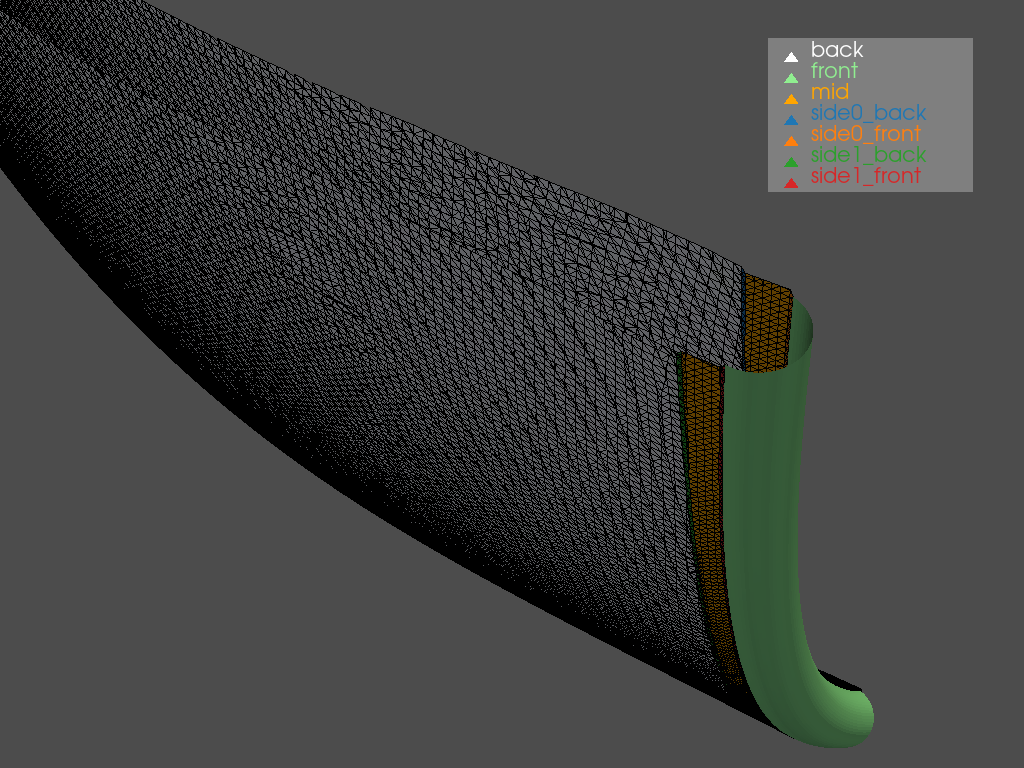

In [24]:
if plot_meshes:
    p1 = pv.Plotter()
    p1.add_mesh(mesh1, color='white', show_edges=True, label='back')
    p1.add_mesh(tor_half, color='lightgreen', label='front')
    p1.add_mesh(mid_add_surf_cut, show_edges=True, color='orange', label='mid')

    cmap = plt.get_cmap('tab10')
    for i, k in enumerate(patches_only.keys()):
        p1.add_mesh(patches_only[k], color=cmap(i), label=k, show_edges=True)
    p1.add_legend()
    p1.camera_position = cpos['final']
    p1.show()

## Merge everything

In [25]:
# Merge all pieces

# Merge the two middle patches (no overlap)
filling_patches_merged = filling_patches['side0'] + filling_patches['side1']

# Merge to back
mesh1_merged = mesh1.merge(filling_patches_merged, merge_points=True)

# Merge to front
result_surf_00 = tor_half.merge(mesh1_merged, merge_points=True).extract_surface().triangulate()

# Clip off overhangs in z
result_surf_0 = result_surf_00.clip('-z', (0,0,area_params.z_rim_min)).clip('z', (0,0,area_params.z_rim_max))

### Some last cleaning steps

In [26]:
# Remove cells with area of zero
result_surf_0 = result_surf_0.compute_cell_sizes(area=True, length=False, volume=False)
zero_area_ids = np.where(result_surf_0['Area']==0)[0]

faces = result_surf_0.faces.reshape(-1,4)
faces_new = np.delete(faces, zero_area_ids, axis=0)

result_surf_1 = pv.PolyData(result_surf_0.points, faces_new.flatten())


In [27]:
# Clean up holes

# Check for holes: should be closed loops
list_loop_sets, dict_open_borders, border_connected_edges = mesh_get_connected_border_loops(result_surf_1, plot_loops=True)
if len(list_loop_sets) == 0:
     # If no loops are found, assume that there are no holes
    print('Found no closed loops, assuming no holes!')
    result_surf = result_surf_1.copy()
    holes_cleaned=True
elif len(list_loop_sets) == 1 and len(dict_open_borders) == 0:
    print('Found one closed loop, probably corresponding to the outer border --> assuming no holes!')
    holes_cleaned = True
    result_surf = result_surf_1.copy()    
else :
    holes_cleaned = False
    
# Break the script if potential holes were found.
assert holes_cleaned, 'Found loops in mesh, check if they should be cleaned!'    

Did not find any closed loops!
Found no closed loops, assuming no holes!


In [28]:
# Clean up holes if needed, then continue manually!

hole_ids_to_process = [] # Put in indices
if not holes_cleaned:
    hole_faces = []
    for s_idx in hole_ids_to_process:
        # Get the point set
        set_tmp = list_loop_sets[s_idx]
        #hole_verts = np.sort(list( list_pointsets[s_idx] ))
        edges_tmp = [set(edge) for edge in border_connected_edges if not set_tmp.isdisjoint(set(edge))] 
        sorted_edges, sorted_vertices = sort_connected_edges(edges_tmp)
        n_triangles = len(set_tmp) - 2
        for i in range(n_triangles):
            hole_faces.append(np.r_[3, sorted_vertices[0], sorted_vertices[1+i], sorted_vertices[2+i]] )
        
    hole_face_array = np.concatenate(hole_faces, axis=0)
    
    result_surf = pv.PolyData( result_surf_1.points, np.r_[result_surf_1.faces, hole_face_array] )


print('Number of connected regions in final mesh: {}.'.format(n_connected_regions(result_surf)))

Number of connected regions in final mesh: 1.


### Calculate normals

In [29]:
# Generate normals and refine their direction

# Generate the initial normals
normals = -1*result_surf.point_normals

# Make a reference mesh, normals should roughly point to it!
mid_mesh_ref = mid_mesh.clip(normal=clip_plane.normal, origin=clip_plane.center)
tree_mid_ref = cKDTree(mid_mesh_ref.points)
_, idx_mid_ref = tree_mid_ref.query(result_surf.points)
vec_to_mid_ref = normalize_vector(mid_mesh_ref.points[idx_mid_ref] - result_surf.points)


# Get angle between normals and vectors to reference --> if it's > 90 degrees, flip the normal
ang_mid_ref = angle_between_vectors_batch(normals, vec_to_mid_ref)
normals[ang_mid_ref > 90] *= -1

# Further refinement of normals
print('Refining normals..')
# For each point, get its neighbor points
neighbor_id_list = mesh_neighbor_id_list(result_surf)
# Refine the normals where necessary
normals_refined = mesh_refine_normals_v1(normals, neighbor_id_list, iterations=1, tolerance_angle=10)

# Save refined normals in the surface, even though they don't get read by pycurv (maybe cell normals would?)
result_surf['Normals_'] = normals_refined


Refining normals..
Iteration 0: Corrected 68 normals. 


### Plot the final result
Note: Since the meshes are cut at the borders for bending energy calculations (because pycurv performs worse close to the border), the uncut meshes are left a bit rough at the upper and lower border.

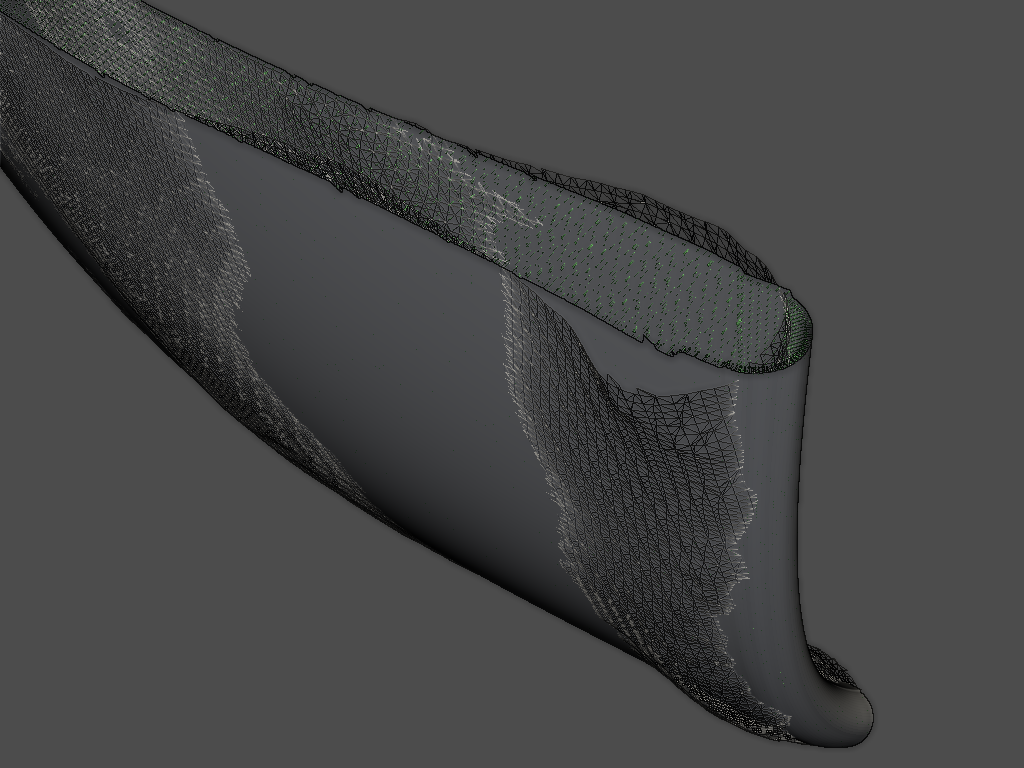

In [30]:
# Plot
p4 = pv.Plotter()
p4.enable_eye_dome_lighting()
p4.add_mesh(result_surf, color='white', show_edges=False)

p4.add_arrows(result_surf.points, normals_refined, color='lightgreen')
p4.add_mesh(rim_mesh, style='wireframe', color='white')

p4.camera_position = cpos['final']
_ = p4.show()


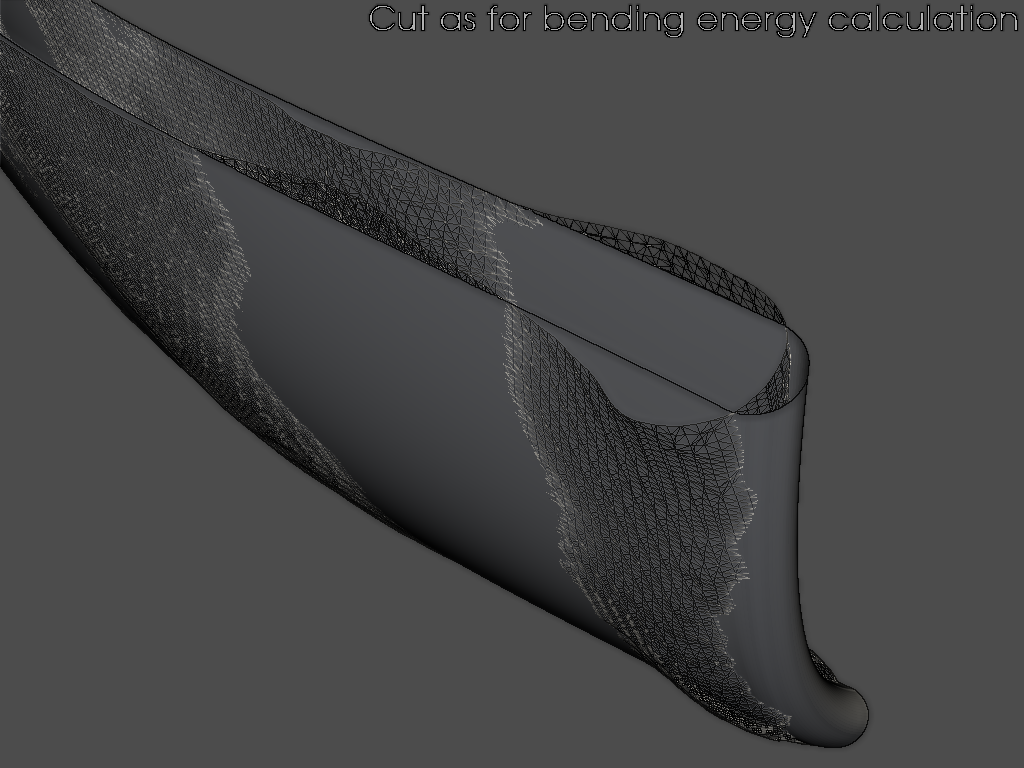

In [31]:
# Cut as for bending energy calculations
zmin = area_params.z_rim_min + area_params.curv_dist
zmax = area_params.z_rim_max - area_params.curv_dist
result_clip = result_surf.clip('-z', (0,0,zmin)).clip('z', (0,0,zmax))
rim_clip = rim_mesh.clip('-z', (0,0,zmin)).clip('z', (0,0,zmax))

# Plot
p5 = pv.Plotter()
p5.add_text('Cut as for bending energy calculation', color='white', position='upper_right')
p5.enable_eye_dome_lighting()
p5.add_mesh(result_clip, color='white', show_edges=False)
p5.add_mesh(rim_clip, style='wireframe', color='white')

p5.camera_position = cpos['final']
_ = p5.show()

## Save mesh

In [32]:
# Save as vtp
if save_mesh:
    result_surf.save(fname_out)